In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ROOT
from ROOT import TFile, TTree, TCanvas, TH2D
from scipy import constants
#plt.rcParams['text.usetex'] = True

from scipy.stats import binned_statistic_2d
import plotly.graph_objects as go

Welcome to JupyROOT 6.22/09


In [3]:
print(constants.physical_constants['proton mass energy equivalent in MeV'][0]/1000)

0.93827208816


In [4]:
f = TFile("selectedEvents_120823.root","READ")
t = f.Get("selectedEvents")

In [5]:
h = ROOT.TH1F("gauss","Example histogram",100,-4,4)
h.FillRandom("gaus")

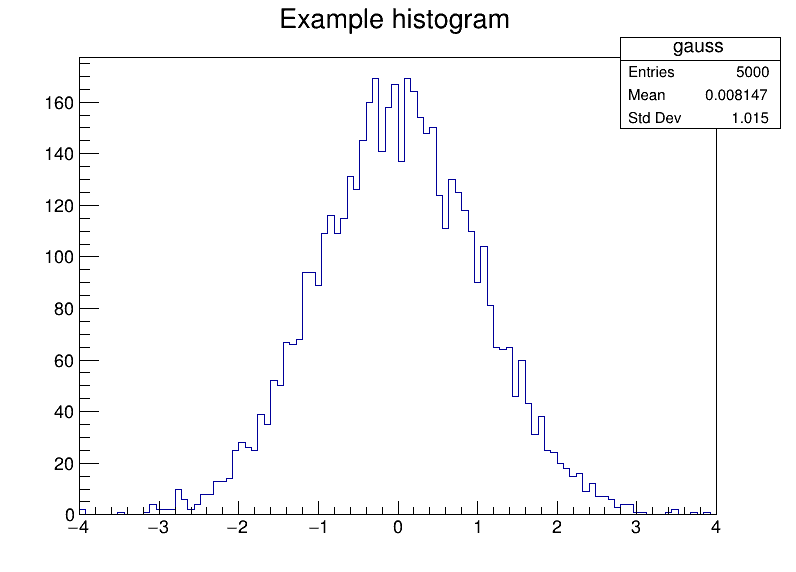

In [6]:
c = ROOT.TCanvas("myCanvasName","The Canvas Title",800,600)
h.Draw()
c.Draw()

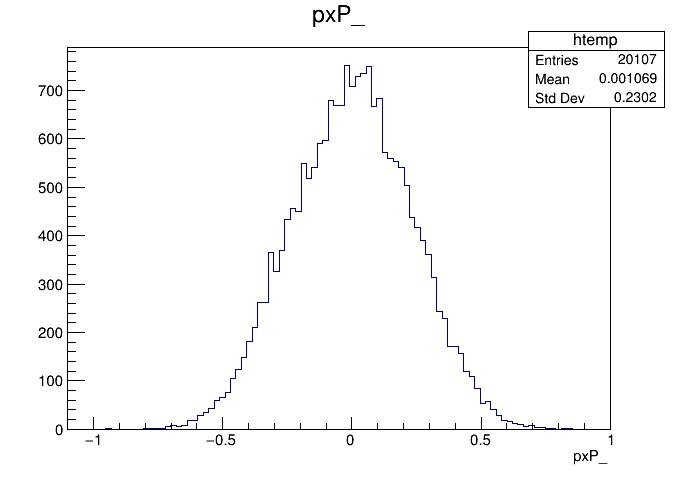

In [7]:
canvas = TCanvas("frNoSC","frNoSC",720,152,682,505)
canvas.cd()
#corr2 = TH2D("corr2","Fractional Difference vs. MCS Reco Momentum, no SC",100,0,2,100,0,2)
f.selectedEvents.Draw("pxP_","","COLZ")
#corr2.GetXaxis().SetTitle("MCS Reco Momentum, no SC [GeV]")
#corr2.GetYaxis().SetTitle("(MCS p (w/ SC) - MCS p (no SC)) / MCS p (no SC)")
canvas.Draw()

In [8]:
t.GetEntry(0)

def getTransverseAxis(eNu, pxMu, pyMu, pzMu):
    pV = np.array([0, 0, eNu])
    pMu = np.array([pxMu, pyMu, pzMu])
    z = np.cross(pV, pMu)
    magZ = np.sqrt( z[0]**2 + z[1]**2 + z[2]**2 )
    #return z / magZ
    return z / np.linalg.norm(z) # same as my magZ eqn above

print(t.eNu_)
print(t.pxMu_)

z = getTransverseAxis(t.eNu_,t.pxMu_,t.pyMu_,t.pzMu_)

print("z: ", z )
#testZ = np.array([ 0.04815974, -0.97140761, -0.23248202]) 

1.9261623620986938
0.029443029314279556
z:  [ 0.99614038  0.08777441 -0.        ]


In [9]:
t.GetEntry(0)

pPi = np.array([t.pxPi_, t.pyPi_, t.pzPi_])
pP = np.array([t.pxP_, t.pyP_, t.pzP_])
print(pPi)
print(pP)

# 1st TKI observable, double-transverse momentum imbalance
def delPTT(z, pPi, pP): 
    pPiTT = np.dot(z,pPi)
    pPTT = np.dot(z,pP)
    return pPiTT + pPTT

print( delPTT(z, pPi, pP) )

[-0.19392665  0.00688269  0.25265351]
[0.18746324 0.32145506 0.31821021]
0.02238119136851674


In [16]:
t.GetEntry(0)
# sum of transverse momenta of the 3 particles
def delPT(pxPi, pxP, pxMu, pyPi, pyP, pyMu): 
    pTMu = np.array([pxMu, pyMu, 0])
    pTP = np.array([pxP, pyP, 0])
    pTPi = np.array([pxPi, pyPi, 0])
    return pTMu + pTPi + pTP

delPT_test = delPT(t.pxPi_, t.pxP_, t.pxMu_, t.pyPi_, t.pyP_, t.pyMu_)
print(delPT_test)

[ 0.02297962 -0.00580735  0.        ]


In [31]:
# longitudinal component, the long way
def pL(pzP, pzMu, pzPi, eP, eMu, ePi, delPT): 
    mP = constants.physical_constants['proton mass energy equivalent in MeV'][0]/1000 
    mN = constants.physical_constants['neutron mass energy equivalent in MeV'][0]/1000
    B = 0.34381
    mA = 22*mN + 18*mP - B
    epsilon = 0.0309
    mA1 = mA - mN + epsilon
    del2 = np.dot(delPT, delPT)
    #pLP = np.array([0, 0, pzP])
    #pLMu = np.array([0, 0, pzMu])
    #pLPi = np.array([0, 0, pzPi])
    parens = mA + pzMu + pzPi + pzP - eMu - ePi - eP
    return 0.5*(parens) - 0.5*((del2+mA1**2)/(parens))

pL_test = pL(t.pzP_, t.pzMu_, t.pzPi_, t.eP_, t.eMu_, t.ePi_, delPT_test)
print(t.pzP_)
print("pL_test: ", pL_test)

def pLGKI(pzP, pzMu, pzPi, eP, eMu, ePi):
    pRest = constants.physical_constants['proton mass energy equivalent in MeV'][0]/1000
    piRest = 139.57/1000 # GeV
    Ecal = eMu + (eP-pRest) + (ePi-piRest) + 0.34381
    #Ecal = (eMu-105.66/1000) + (eP-pRest) + (ePi-135/1000) + 0.34381
    return pzMu + pzP + pzPi - Ecal

pLGKI_test = pLGKI(t.pzP_, t.pzMu_, t.pzPi_, t.eP_, t.eMu_, t.ePi_)
print("pLGKI_test: ", pLGKI_test)

0.3650803864002228
pL_test:  0.018483526071889855
pLGKI_test:  -0.1561373647158526


In [21]:
# 3rd TKI observable, boosting angle
def delAlphaT(pxMu, pyMu, delPT): 
    pTMu = np.array([pxMu, pyMu, 0])
    magPTMu = np.sqrt( pTMu[0]**2 + pTMu[1]**2 + pTMu[2]**2 )
    magDelPT = np.sqrt( delPT[0]**2 + delPT[1]**2 + delPT[2]**2 )
    dot = np.dot(-pTMu,delPT)
    return np.arccos(dot / (magPTMu * magDelPT))

delAlphaT_test = delAlphaT(t.pxMu_, t.pyMu_, delPT_test)
print(delAlphaT_test)

1.9062184509926832


In [22]:
# items to plot
delPTT_list = []
pL_list = []
pLGKI_list = []
pN_list = []
pNGKI_list = []
delAlphaT_list = []

entries = t.GetEntries()

# main loop
for e in range(entries):

    t.GetEntry(e)
    
    pPi = np.array([t.pxPi_, t.pyPi_, t.pzPi_])
    pP = np.array([t.pxP_, t.pyP_, t.pzP_])
    
    z = getTransverseAxis(t.eNu_,t.pxMu_,t.pyMu_,t.pzMu_)
    delPT_entry = delPT(t.pxPi_, t.pxP_, t.pxMu_, t.pyPi_, t.pyP_, t.pyMu_)
    
    delPTT_list.append( delPTT(z, pPi, pP) )
    delAlphaT_list.append( delAlphaT(t.pxMu_, t.pyMu_, delPT_entry ) )
    
    pL_entry = pL(t.pzP_, t.pzMu_, t.pzPi_, t.eP_, t.eMu_, t.ePi_, delPT_test)
    pLGKI_entry = pLGKI(t.pzP_, t.pzMu_, t.pzPi_, t.eP_, t.eMu_, t.ePi_)
    
    pL_list.append( pL_entry )
    pLGKI_list.append( pLGKI_entry )
    
    pN = np.sqrt( np.dot(delPT_entry, delPT_entry) + np.dot(pL_entry, pL_entry) )
    pN_list.append(pN)
    
    pNGKI = np.sqrt( np.dot(delPT_entry, delPT_entry) + np.dot(pLGKI_entry, pLGKI_entry) )
    pNGKI_list.append(pNGKI)
    
    #print("pPi:", pPi)
    #print("pP:", pP)
    
#print("delPTT_list: ", delPTT_list)
print("delAlphaT_list: ", delAlphaT_list)
    
delPTT_arr = np.asarray(delPTT_list)
delAlphaT_arr = np.asarray(delAlphaT_list)
pL_arr = np.asarray(pL_list)
pLGKI_arr = np.asarray(pLGKI_list)
pN_arr = np.asarray(pN_list)
pNGKI_arr = np.asarray(pNGKI_list)
    

delAlphaT_list:  [1.9062184509926832, 1.9118402329549373, 2.6514036174622393, 2.094990616796469, 2.8274733566816677, 1.3593904941765191, 2.253023407019846, 2.640332253521577, 0.46666771721065675, 2.422389104263278, 0.8231134407318759, 2.4527823468643146, 2.940178767388513, 1.3880142613524336, 0.8432718134696019, 2.3193551598340685, 2.7763376865299243, 2.9640783610219885, 1.6958769914811471, 1.4084496807423101, 1.201608890379383, 2.5939572051171846, 1.913452729899137, 0.10937447390569578, 0.9125375827835598, 2.6348663636851968, 2.996307349880351, 2.9973651054119, 2.65543723464693, 3.1353287479317657, 2.8035353893125423, 2.956053884867644, 0.2833450171424536, 2.8721749812894797, 2.9023738937565327, 0.10472984021796443, 0.1348529464874933, 2.7122245306768016, 1.9573831086774234, 2.384874814823781, 1.2408485977792043, 1.8473539938091068, 2.3082798937410627, 2.9410024477248387, 2.1820879102558015, 2.84022997460297, 1.6051060420519088, 0.7486457196690295, 2.567187570323994, 0.980834743821405

<IPython.core.display.Javascript object>


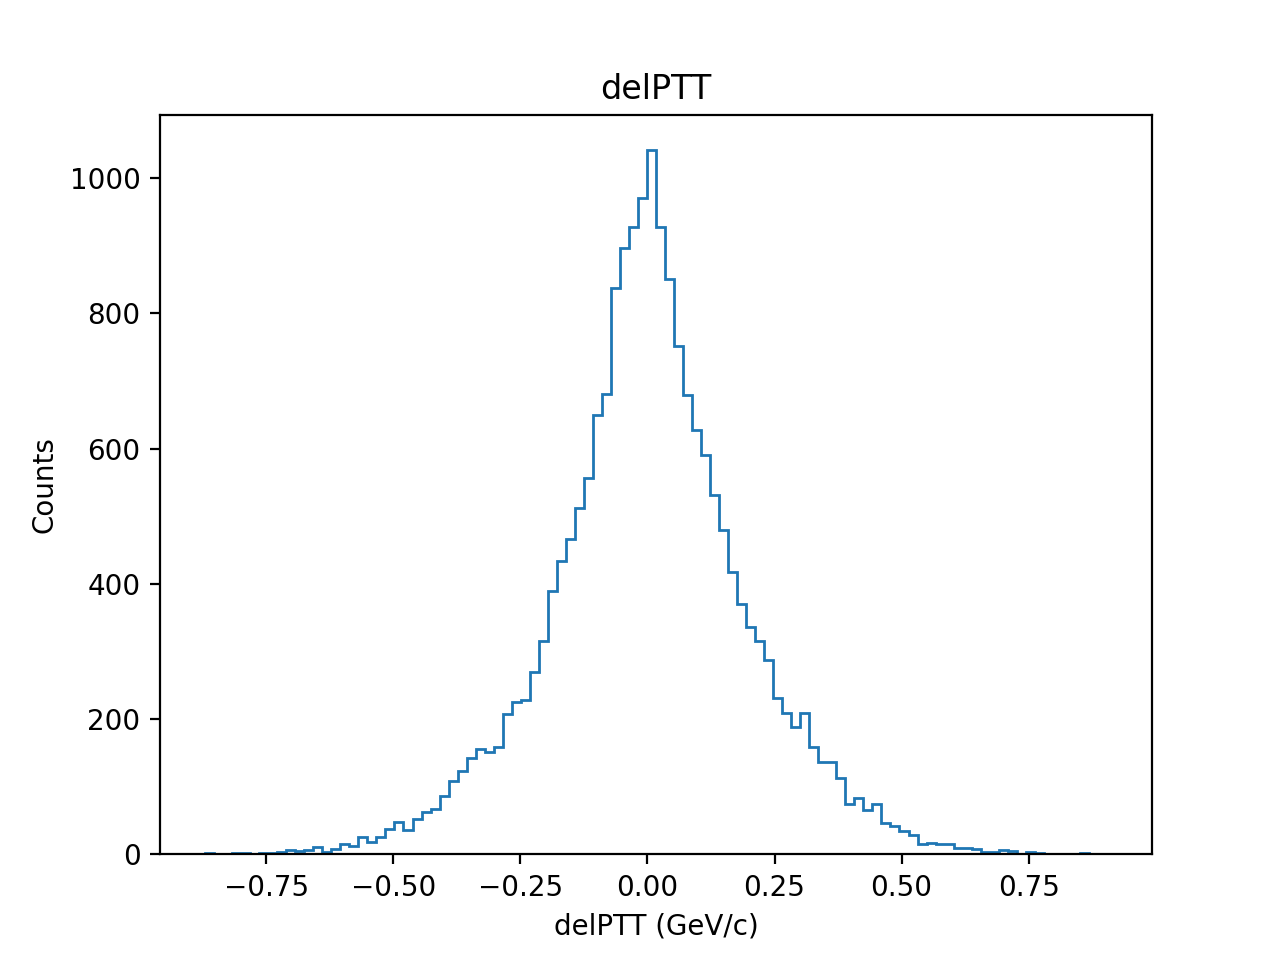

Text(0.5, 1.0, 'delPTT')

In [23]:
ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

counts, bins = np.histogram(delPTT_arr, bins=100)
plt.stairs(counts, bins)
plt.xlabel('delPTT (GeV/c)')
plt.ylabel('Counts')
plt.title('delPTT')

<IPython.core.display.Javascript object>


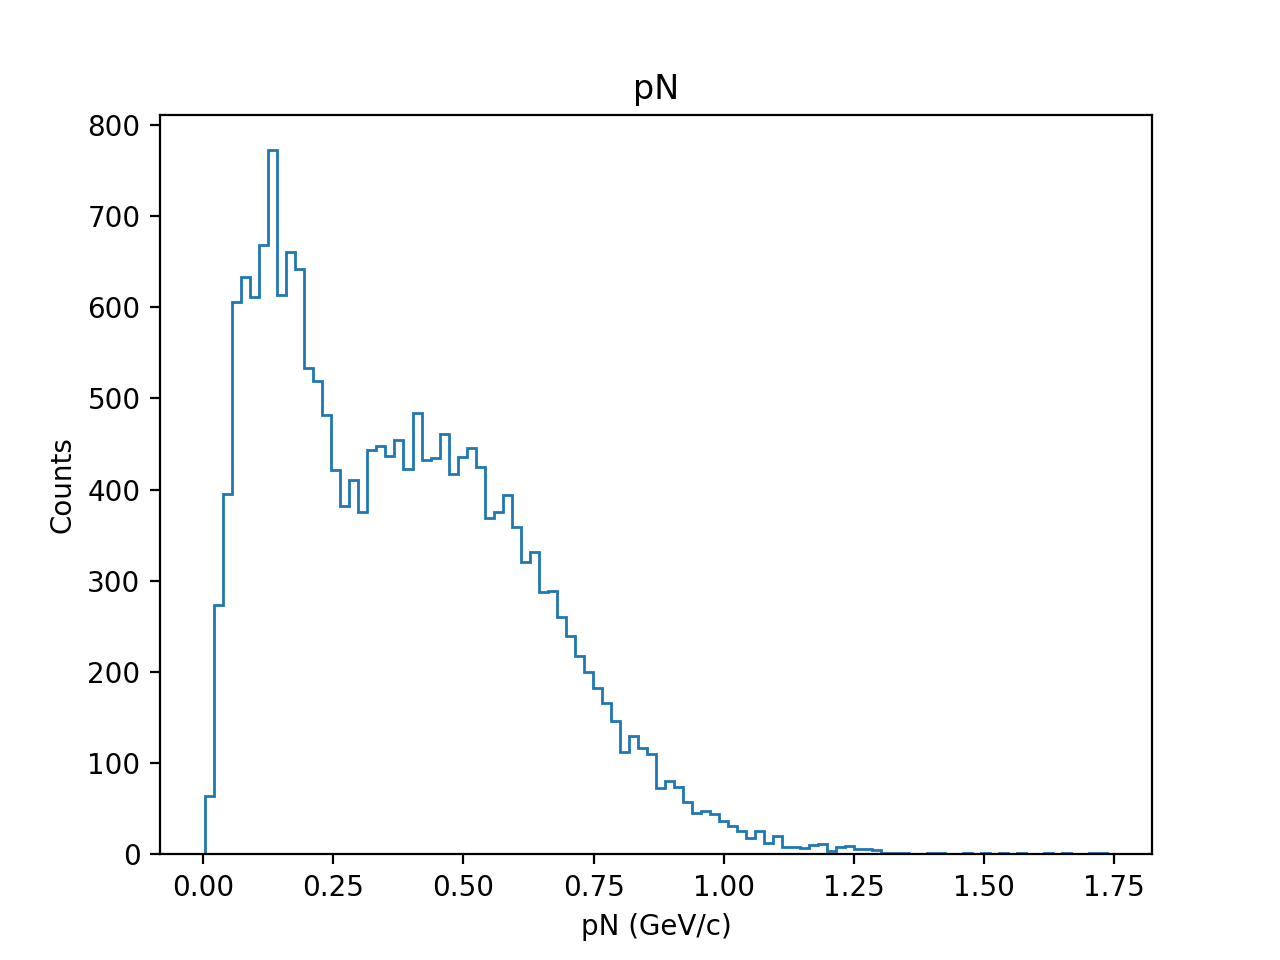

Text(0.5, 1.0, 'pN')

In [24]:
ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

counts, bins = np.histogram(pN_arr, bins=100)
plt.stairs(counts, bins)
plt.xlabel('pN (GeV/c)')
plt.ylabel('Counts')
plt.title('pN')

<IPython.core.display.Javascript object>


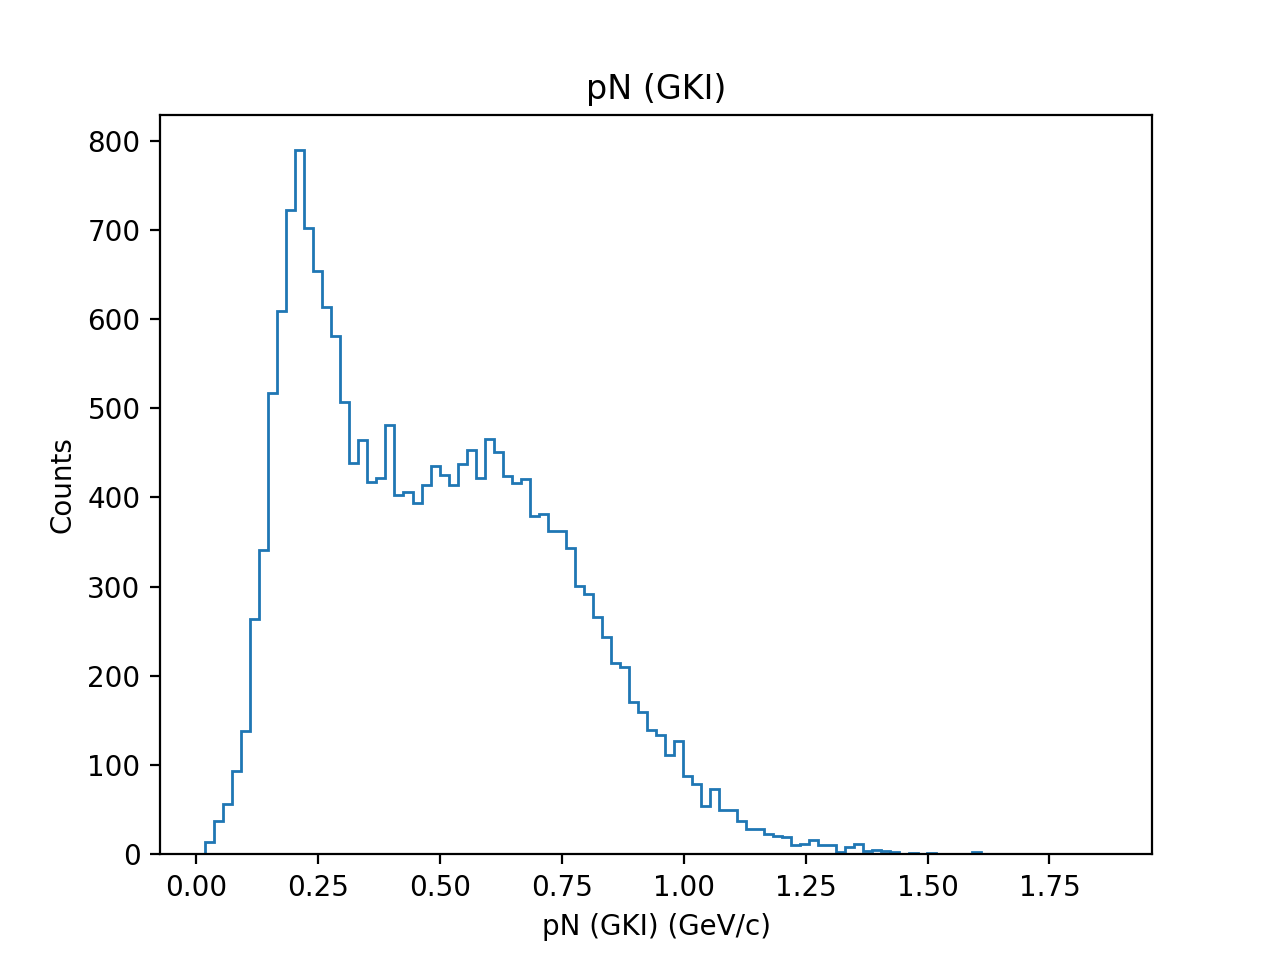

Text(0.5, 1.0, 'pN (GKI)')

In [25]:
ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

counts, bins = np.histogram(pNGKI_arr, bins=100)
plt.stairs(counts, bins)
plt.xlabel('pN (GKI) (GeV/c)')
plt.ylabel('Counts')
plt.title('pN (GKI)')

<IPython.core.display.Javascript object>


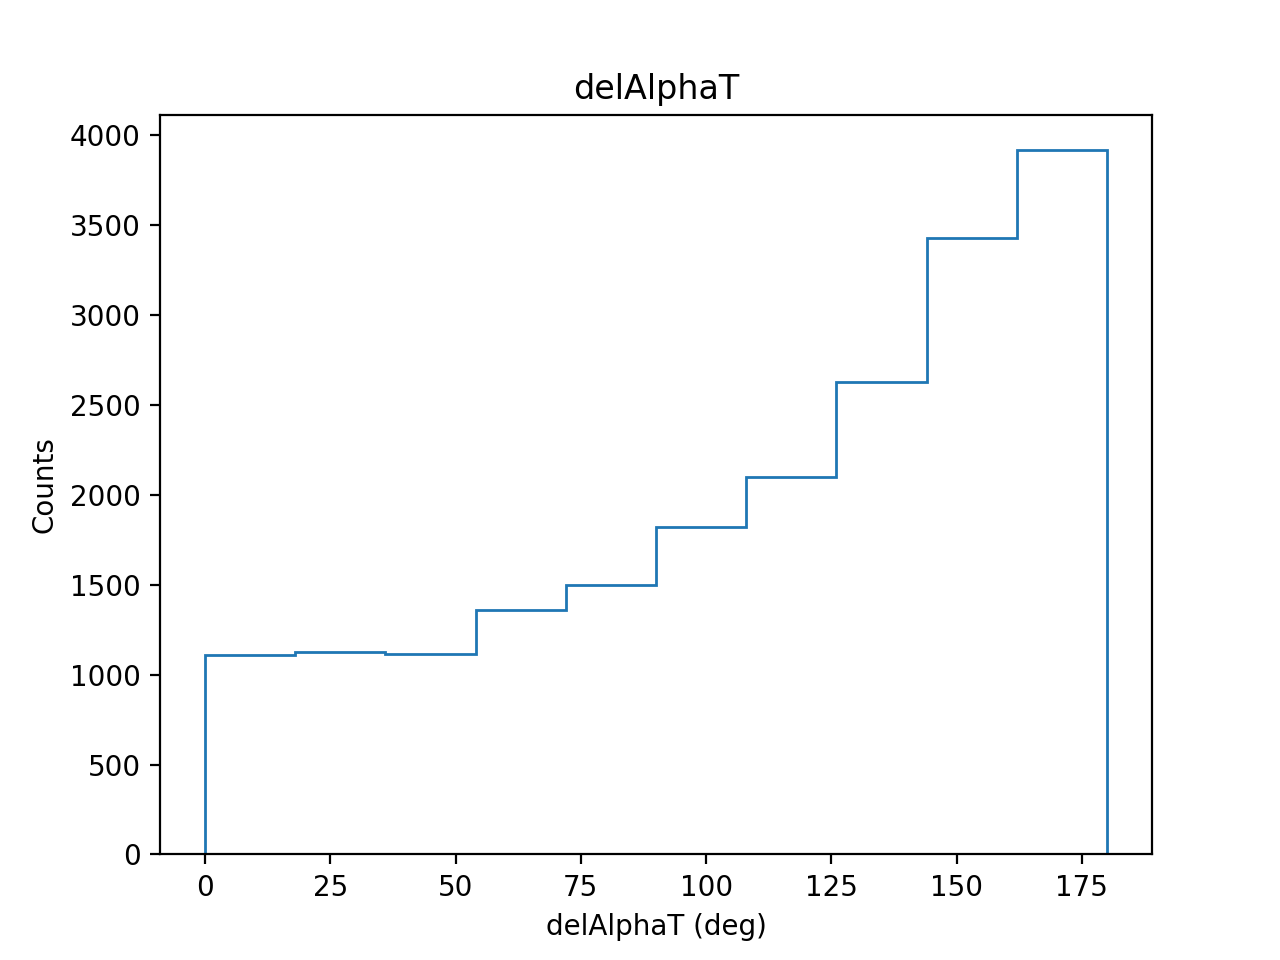

Text(0.5, 1.0, 'delAlphaT')

In [26]:
delAlphaT_deg = delAlphaT_arr*(180/np.pi)

ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

counts, bins = np.histogram(delAlphaT_deg, bins=10)
plt.stairs(counts, bins)
plt.xlabel('delAlphaT (deg)')
plt.ylabel('Counts')
plt.title('delAlphaT')

<IPython.core.display.Javascript object>


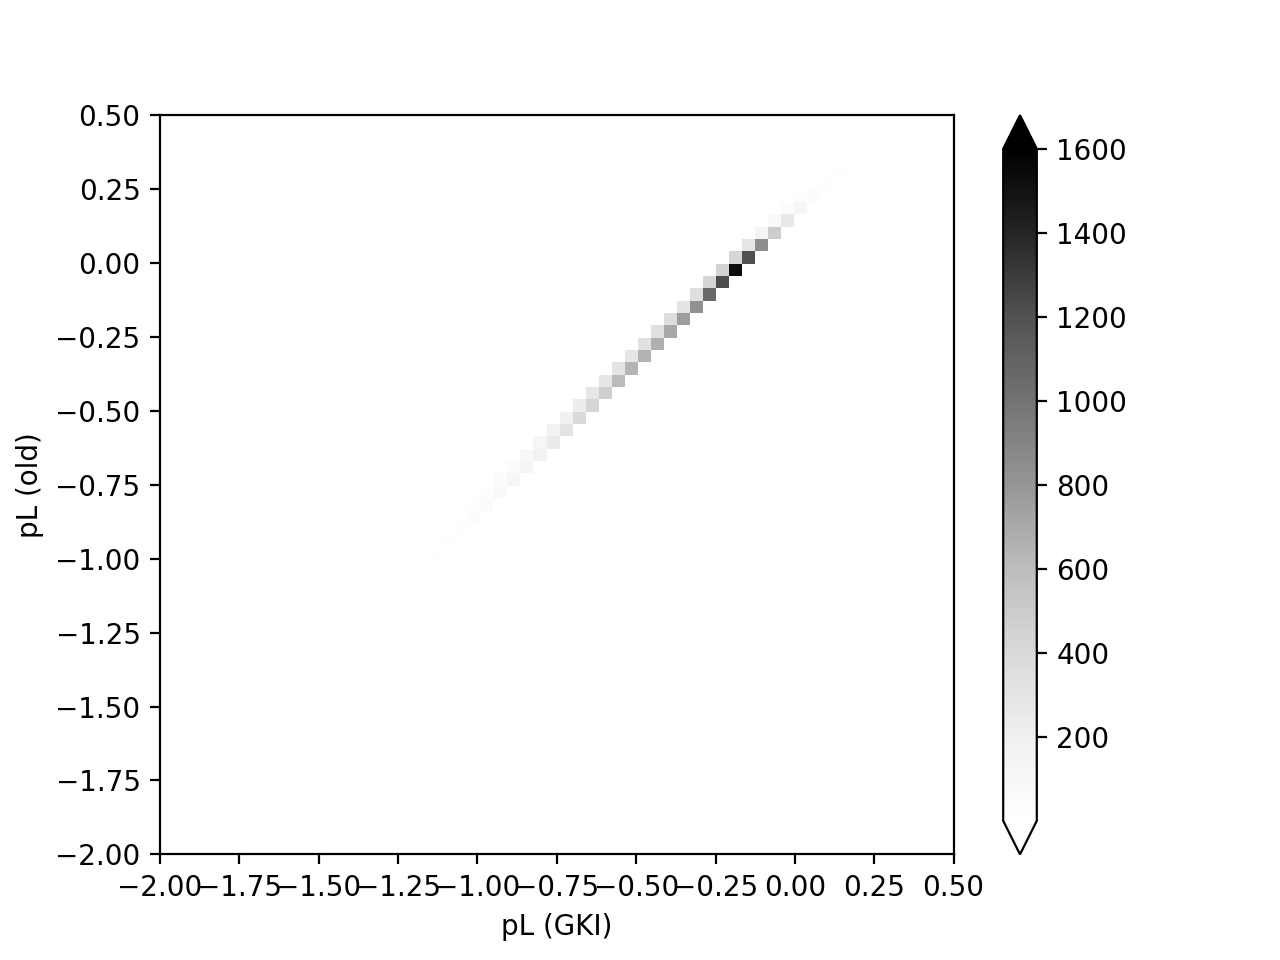

In [27]:
ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

#x, y = np.histogram2d(pL_arr, pLGKI_arr)

#pL_arr[pL_arr==0] = np.NaN
#pLGKI_arr[pLGKI_arr==0] = np.NaN

#matplotlib axes are x, y
plt.hist2d(pLGKI_arr, pL_arr, bins=(50, 50), cmap=plt.cm.Greys)
#plt.hist2d(pLGKI_arr, pL_arr, bins=(50, 50), range=np.array([(-1, 1), (-1, 1)]), cmap=plt.cm.jet)
plt.show()
#xlim([-6, 6])
#ylim([-4.5, 4.5])
#plt.imshow(x,y)
#plt.stairs(x, y)
#ax.set(xlim=(-2, 2), ylim=(-2, 2))
plt.xlabel('pL (GKI)')
ax.set_yticks([-2.00, -1.75, -1.50, -1.25, -1.00, -0.75, -0.50, -0.25, 0, 0.25, 0.50]) 
ax.set_xticks([-2.00, -1.75, -1.50, -1.25, -1.00, -0.75, -0.50, -0.25, 0, 0.25, 0.50]) 
plt.ylabel('pL (old)')
plt.colorbar(extend='both')
plt.clim(1, 1600);
#plt.title('delAlphaT')

In [13]:
# Load numpy arrays from csv
lProtonMom = np.loadtxt('lProtonMom1.csv', delimiter=',')
muonMom = np.loadtxt('muonMom1.csv', delimiter=',')
pionMom = np.loadtxt('pionMom1.csv', delimiter=',')

AttributeError: 'numpy.ndarray' object has no attribute 'type'

<IPython.core.display.Javascript object>


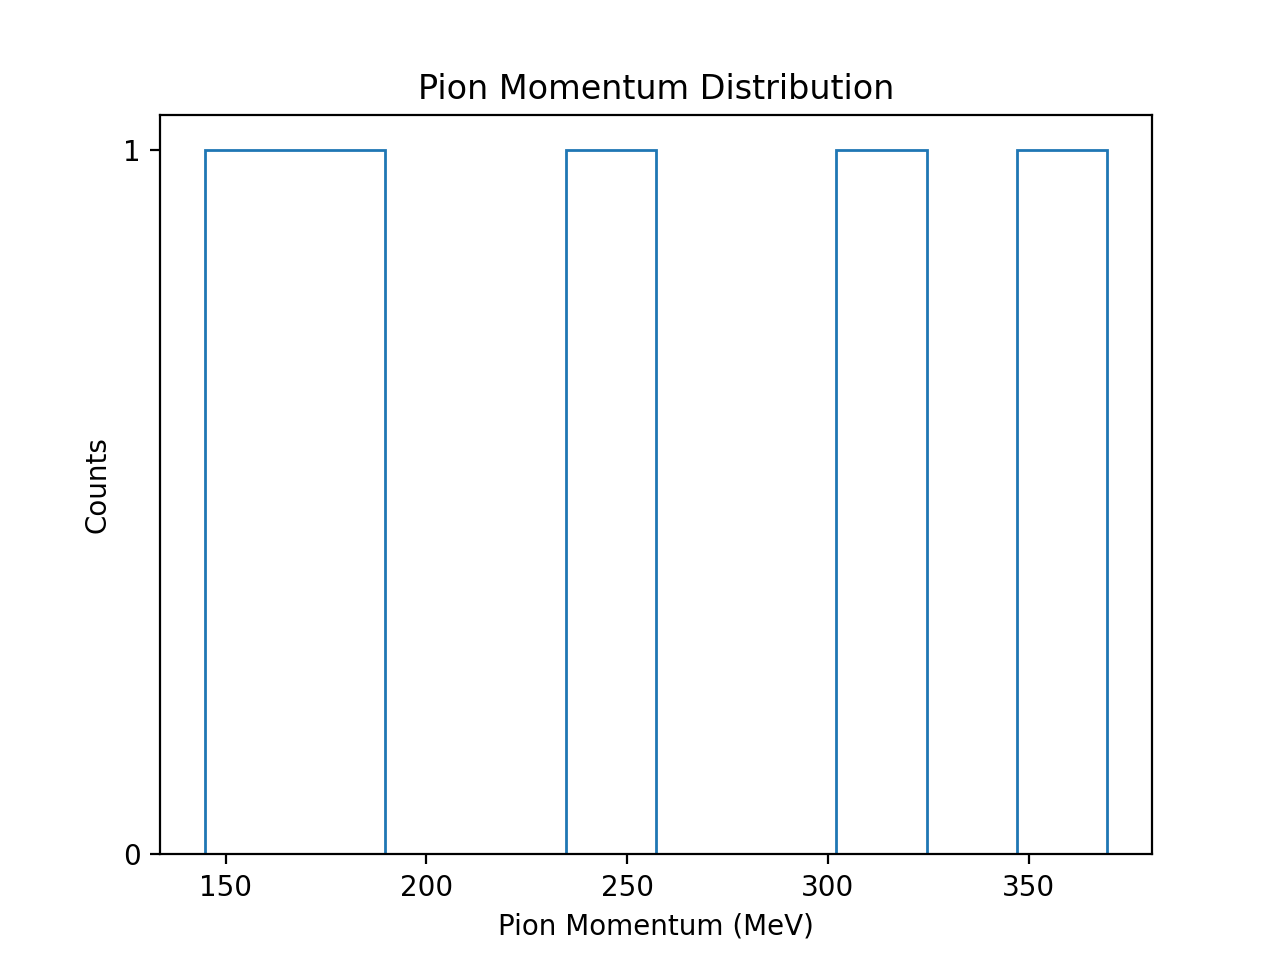

Text(0.5, 1.0, 'Pion Momentum Distribution')

In [12]:
ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

counts, bins = np.histogram(pionMom)
plt.stairs(counts, bins)
plt.xlabel('Pion Momentum (MeV)')
plt.ylabel('Counts')
plt.title('Pion Momentum Distribution')

In [ ]:
ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

counts, bins = np.histogram(lProtonMom)
plt.stairs(counts, bins)
plt.xlabel('Leading Proton Momentum (MeV)')
plt.ylabel('Counts')
plt.title('Leading Proton Momentum Distribution')

In [ ]:
# Load ntuple numpy arrays from csv
ntuple_lProtonMom = np.loadtxt('ntuple_lProtonMom_101523.csv', delimiter=',')
ntuple_muonMom = np.loadtxt('ntuple_muonMom_101523.csv', delimiter=',')
ntuple_pionMom = np.loadtxt('ntuple_pionMom_101523.csv', delimiter=',')

ntuple_lProtonAng = np.loadtxt('ntuple_lProtonAng_101523.csv', delimiter=',')
ntuple_muonAng = np.loadtxt('ntuple_muonAng_101523.csv', delimiter=',')
ntuple_pionAng = np.loadtxt('ntuple_pionAng_101523.csv', delimiter=',')

ntuple_weights = np.loadtxt('ntuple_weights_101523.csv', delimiter=',')

In [ ]:
targetPOT = 1.3e21
sumPOT = 8.98e20

scale = targetPOT / sumPOT
print("Scale is: ", scale)

totalEvents = np.sum(ntuple_weights)*scale
print("totalEvents: ", totalEvents)

In [ ]:
ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

#ax.hist(ntuple_muonMom, bins=100)

#counts, bins = np.histogram(ntuple_muonMom, bins=100)
counts, bins = np.histogram(ntuple_muonMom, bins=100, weights=ntuple_weights)
scaledCounts = counts*scale
plt.stairs(scaledCounts, bins, label="1.3e21 POT")
plt.stairs(counts, bins, label="8.98e20 POT")
#plt.hist(ntuple_muonMom, bins=100, weights=ntuple_weights)
plt.xlabel('Muon Momentum (MeV/c)')
plt.ylabel('Counts')
plt.title('Muon Momentum Distribution')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

In [ ]:
ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)


counts, bins = np.histogram(ntuple_pionMom, bins=100, weights=ntuple_weights)
scaledCounts = counts*scale
plt.stairs(scaledCounts, bins, label="1.3e21 POT")
plt.stairs(counts, bins, label="8.98e20 POT")
plt.xlim(0, 2000)
plt.xlabel('Pion Momentum (MeV/c)')
plt.ylabel('Counts')
plt.title('Pion Momentum Distribution')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

In [ ]:
ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

counts, bins = np.histogram(ntuple_lProtonMom, bins=100, weights=ntuple_weights)
scaledCounts = counts*scale
plt.stairs(scaledCounts, bins, label="1.3e21 POT")
plt.stairs(counts, bins, label="8.98e20 POT")
plt.xlabel('Leading Proton Momentum (MeV/c)')
plt.ylabel('Counts')
plt.title('Leading Proton Momentum Distribution')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

In [ ]:
ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

counts, bins = np.histogram(ntuple_muonAng, bins=20, weights=ntuple_weights)
scaledCounts = counts*scale
plt.stairs(scaledCounts, bins, label="1.3e21 POT")
plt.stairs(counts, bins, label="8.98e20 POT")
plt.xlabel('cos(theta)')
plt.ylabel('counts')
plt.title('Muon Angle wrt Beam')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper left')

In [ ]:
ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

counts, bins = np.histogram(ntuple_pionAng, bins=20, weights=ntuple_weights)
scaledCounts = counts*scale
plt.stairs(scaledCounts, bins, label="1.3e21 POT")
plt.stairs(counts, bins, label="8.98e20 POT")
plt.xlabel('cos(theta)')
plt.ylabel('counts')
plt.title('Pion Angle wrt Beam')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper left')

In [ ]:
ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

counts, bins = np.histogram(ntuple_lProtonAng, bins=20, weights=ntuple_weights)
scaledCounts = counts*scale
plt.stairs(scaledCounts, bins, label="1.3e21 POT")
plt.stairs(counts, bins, label="8.98e20 POT")
plt.xlabel('cos(theta)')
plt.ylabel('counts')
plt.title('Leading Proton Angle wrt Beam')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper left')

In [ ]:
%jsroot on #don't run this one! doesn't work (but is cool and interactive if it does)